In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D


In [5]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [6]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    # Adjust scaleFactor to be greater than 1
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)

    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x, y), (x+w, y+h), (51, 181, 155), 3)

    if text != '':
        # Modify the text placement as needed
        plate_img = cv2.putText(plate_img, text, (x-w//2, y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate

In [7]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [8]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

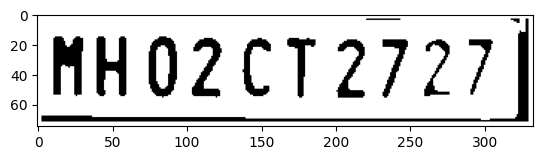

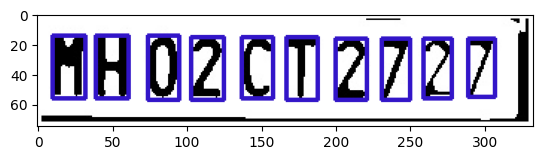

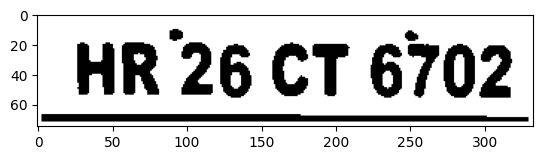

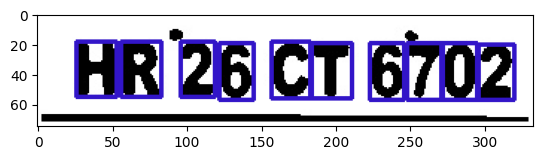

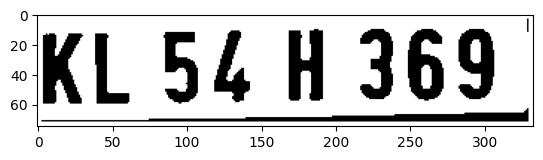

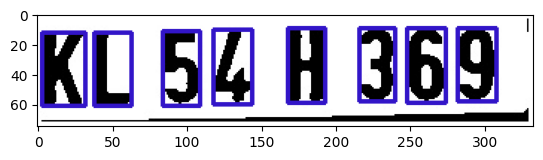

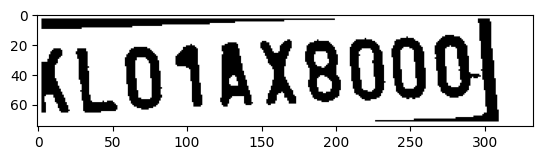

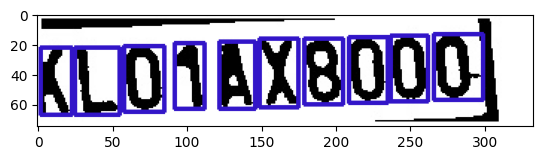

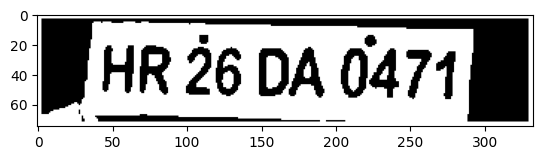

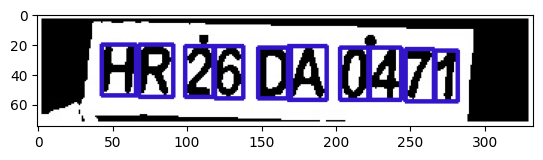

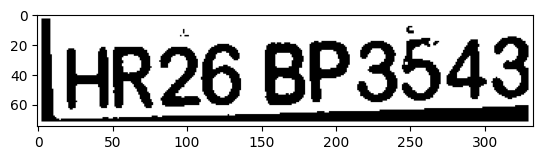

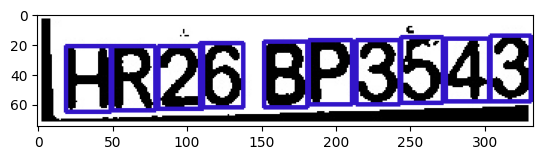

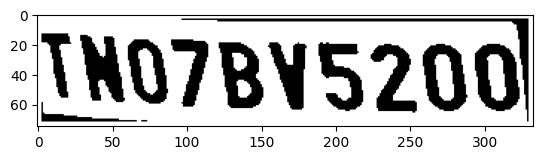

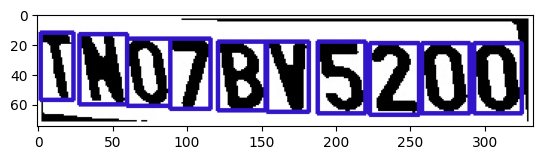

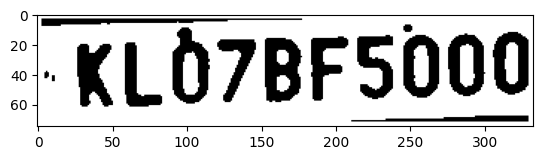

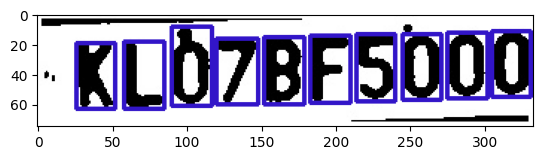

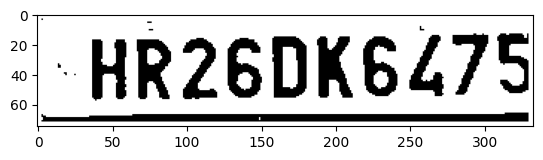

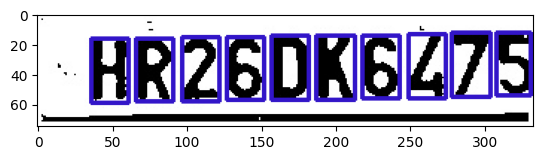

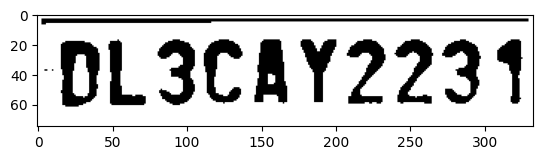

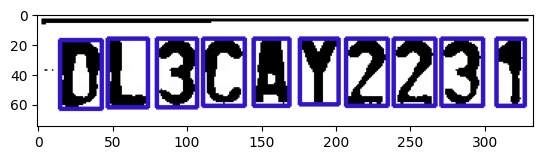

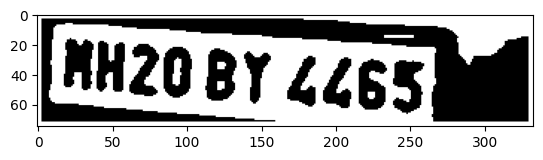

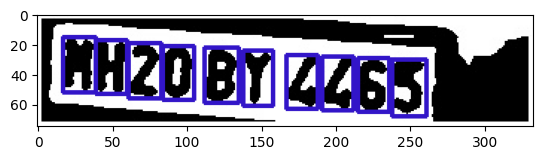

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def process_images_in_folder(folder_path):
    characters_array = []  # Array to store segmented characters

    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Iterate through each image file in the folder
    for image_file in image_files:
        # Read the image
        img = cv2.imread(os.path.join(folder_path, image_file))

        # Getting plate from the processed image
        output_img, plate = detect_plate(img)

        # Segment characters from the license plate
        char = segment_characters(plate)
        characters_array.append(char)  # Store segmented characters

    return characters_array  # Return the array of segmented characters

# Call the function to process images in the folder
characters = process_images_in_folder('testing-folder/')

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

In [11]:
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = "D:/try try/data/data"
train_generator = train_datagen.flow_from_directory(
        "D:/try try/data/data/train",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')


validation_generator = train_datagen.flow_from_directory(
        "D:/try try/data/data/val",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [12]:
import numpy as np

# Initialize empty lists to store images and labels
X_train = []
y_train = []

# Iterate through training data generator to extract batches
for i in range(len(train_generator)):
    # Extract batch of images and labels
    batch_X, batch_y = train_generator.next()

    # Append batch to X_train and y_train
    X_train.append(batch_X)
    y_train.append(batch_y)

# Concatenate batches to create final X_train and y_train arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Do the same for the validation data generator if needed
# Initialize empty lists to store images and labels
X_val = []
y_val = []

# Iterate through validation data generator to extract batches
for i in range(len(validation_generator)):
    # Extract batch of images and labels
    batch_X, batch_y = validation_generator.next()

    # Append batch to X_val and y_val
    X_val.append(batch_X)
    y_val.append(batch_y)

# Concatenate batches to create final X_val and y_val arrays
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)


In [13]:
from collections import Counter
from sklearn.model_selection import train_test_split

# Compute the number of unique classes in y_val
num_classes = len(np.unique(y_val))

# Define the test size
test_size = 0.2  # You can adjust this value according to your preference

# Compute the number of instances per class needed for one instance in the test set
instances_per_class_test = min(1, int(len(y_val) / num_classes))

# Compute the total number of instances needed for the test set with the specified test size
total_instances_test = int(len(y_val) * test_size)

# Ensure each class has at least one instance in the test set
instances_per_class_test = min(instances_per_class_test, total_instances_test // num_classes)

# Compute the remaining instances to allocate based on the specified test size
remaining_instances_test = total_instances_test - instances_per_class_test * num_classes

# Count the occurrences of each class in y_val
class_counts = Counter(y_val)

# Initialize lists to store the indices for the test set
test_indices = []

# Iterate over each class and randomly select instances for the test set
for class_label in class_counts.keys():
    # Get the indices of instances with the current class label
    class_indices = np.where(y_val == class_label)[0]

    # Ensure at least one instance is selected for the test set
    if len(class_indices) > 0:
        test_indices.extend(np.random.choice(class_indices, instances_per_class_test, replace=False))

# Randomly select the remaining instances to meet the specified test size
if remaining_instances_test > 0:
    remaining_indices = np.setdiff1d(np.arange(len(y_val)), test_indices)
    test_indices.extend(np.random.choice(remaining_indices, remaining_instances_test, replace=False))

# Split the data based on the selected indices
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=test_size, random_state=42)


In [14]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [15]:
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

def create_model(lr=1e-4, decay=1e-4/25, training=False, output_shape=None):
    baseModel = MobileNetV2(weights="imagenet",
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.3)(headModel)  # Adjusted dropout rate
    headModel = Dense(output_shape, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    if training:
        # Define trainable layers
        for layer in baseModel.layers:
            layer.trainable = True
        # Compile model
        optimizer = Adam(lr=lr, decay=decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model


In [16]:
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

def create_model(num_classes):
    baseModel = MobileNetV2(weights="imagenet",
                            include_top=False,
                            input_shape=(80, 80, 3))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = True

    return model

# Update the number of classes dynamically
num_classes = len(np.unique(y_train))

# Create the model
model = create_model(num_classes)

# Compile the model with the Adam optimizer
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
import tensorflow as tf
from keras import layers, models
from keras.applications import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from keras.utils import to_categorical

# Define your model architecture
def create_model(num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model


# Set the number of classes
num_classes = 36

# Create your model
model = create_model(num_classes)

# Compile the model
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define your callbacks
my_checkpointer = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=0),
    ModelCheckpoint(filepath="License_character_recognition_weight.h5", verbose=1, save_weights_only=True)
]

# Calculate the number of unique classes in the labels
num_classes = len(np.unique(y_train))

# One-hot encode the labels
trainY_one_hot = to_categorical(y_train, num_classes=num_classes)
testY_one_hot = to_categorical(y_test, num_classes=num_classes)

# Define the target image size to match the input shape of the model
target_size = (80, 80)

# Define the image data generator
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest"
)

BATCH_SIZE=32
# Train the model using the augmented data generator
train_datagen = image_gen.flow_from_directory(
    directory="D:/try try/data/data/train",
    target_size=target_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = validation_datagen.flow_from_directory(
    directory="D:/try try/data/data/val",
    target_size=target_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Number of batches in the training generator:", len(train_datagen))
print("Total number of samples in the training dataset:", train_datagen.samples)


# Train the model with the callback
result = model.fit(
    train_datagen,
    steps_per_epoch=len(train_datagen),
    validation_data=validation_datagen,
    validation_steps=len(validation_datagen),
    epochs=10,
)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Number of batches in the training generator: 27
Total number of samples in the training dataset: 864
Epoch 1/10


27/27 [==============================] - 10s 193ms/step - loss: 3.0204 - accuracy: 0.2315 - val_loss: 1.9567 - val_accuracy: 0.5093
Epoch 2/10
27/27 [==============================] - 4s 154ms/step - loss: 1.2965 - accuracy: 0.6562 - val_loss: 0.9126 - val_accuracy: 0.8102
Epoch 3/10
27/27 [==============================] - 4s 148ms/step - loss: 0.5400 - accuracy: 0.8414 - val_loss: 0.5440 - val_accuracy: 0.8565
Epoch 4/10
27/27 [==============================] - 4s 150ms/step - loss: 0.3785 - accuracy: 0.8958 - val_loss: 0.3794 - val_accuracy: 0.9120
Epoch 5/10
27/27 [==============================] - 5s 169ms/step - loss: 0.2482 - accuracy: 0.9282 - val_loss: 0.3011 - val_accuracy: 0.9167
Epoch 6/10
27/27 [==============================] - 5s 186ms/step - loss: 0.1997 - accuracy: 0.9491 - 

In [18]:
model.summary()
model.save('mobilenet.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 40, 40, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 40, 40, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 40, 40, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 40, 40, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 40, 40, 32)        128 

c:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


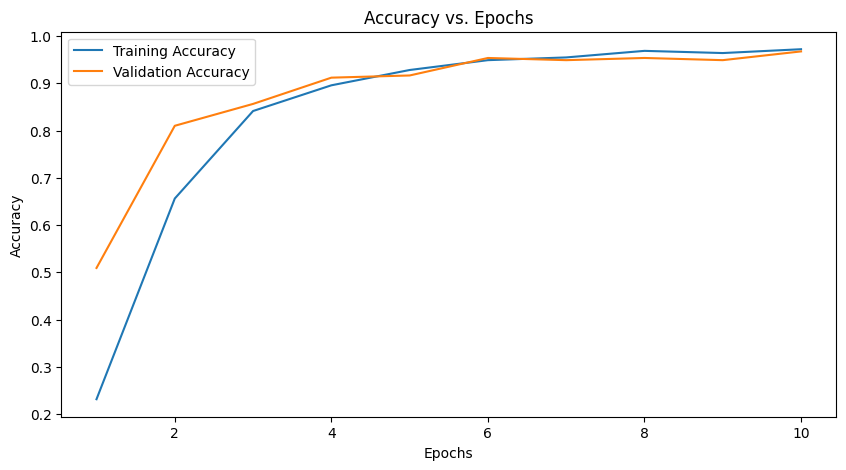

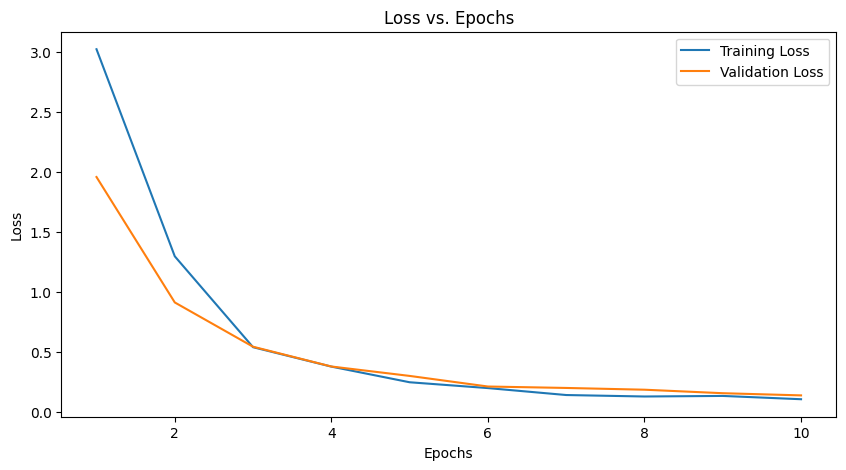

In [19]:
import matplotlib.pyplot as plt

# Extracting training history
train_acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
train_loss = result.history['loss']
val_loss = result.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
import numpy 
from keras.models import load_model
def show_results(characters):
    model=load_model('models.h5')
    dic = {}
    characters_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters_map):
        dic[i] = c

    output = []
    for ch in characters[1]: # accessing the characters of the 7th image (index 6)
        img = cv2.resize(ch, (80, 80), interpolation=cv2.INTER_AREA)  # Resize to match model input shape
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB by repeating the single channel 3 times
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        y_pred_probs = model.predict(img)

        # Convert probabilities to class predictions
        y_pred_classes = y_pred_probs.argmax(axis=-1)[0]  # Assuming there's only one prediction
        character = dic[y_pred_classes]
        output.append(character)  # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results(characters))


1/1 [==============================] - 0s 30ms/step
HR26CT6702


In [21]:
predicted_plate = show_results(characters)
ground_truth_plate = 'HR26CT6702'  # Assuming this is the ground truth plate number

# Calculate accuracy
correct_predictions = sum(1 for pred, truth in zip(predicted_plate, ground_truth_plate) if pred == truth)
total_characters = len(ground_truth_plate)
accuracy = correct_predictions / total_characters

print("Accuracy:", accuracy)


1/1 [==============================] - 0s 34ms/step
Accuracy: 1.0


1/1 [==============================] - 0s 59ms/step


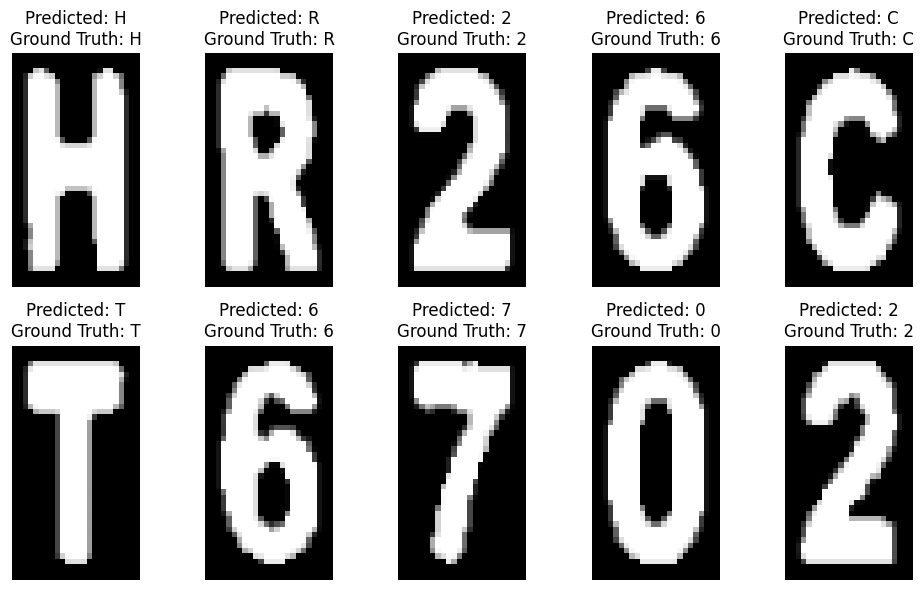

In [22]:
import matplotlib.pyplot as plt

predicted_plate = show_results(characters)
ground_truth_plate = 'HR26CT6702'  # Assuming this is the ground truth plate number

# Plot characters along with ground truth labels
plt.figure(figsize=(10, 6))
for i, (pred_char, truth_char) in enumerate(zip(predicted_plate, ground_truth_plate)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(characters[1][i], cmap='gray')  # assuming 7th image characters are being plotted
    plt.title(f'Predicted: {pred_char}\nGround Truth: {truth_char}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/10
27/27 [==============================] - 9s 210ms/step - loss: 0.0325 - accuracy: 0.9873 - f1_m: 0.9872 - precision_m: 0.9884 - recall_m: 0.9861 - val_loss: 0.0359 - val_accuracy: 0.9769 - val_f1_m: 0.9784 - val_precision_m: 0.9807 - val_recall_m: 0.9762
Epoch 2/10
27/27 [==============================] - 3s 124ms/step - loss: 0.0253 - accuracy: 0.9931 - f1_m: 0.9925 - precision_m: 0.9931 - recall_m: 0.9919 - val_loss: 0.0301 - val_accuracy: 0.9861 - val_f1_m: 0.9866 - val_precision_m: 0.9866 - val_recall_m: 0.9866
Epoch 3/10
27/27 [==============================] - 4s 140ms/step - loss: 0.0230 - accuracy: 0.9919 - f1_m: 0.9913 - precision_m: 0.9919 - recall_m: 0.9907 - val_loss: 0.0305 - val_accuracy: 0.9954 - val_f1_m: 0.9955 - val_precision_m: 0.9955 - val_recall_m: 0.9955
Epoch 4/10
27/27 [==============================] - 3s 124ms/step - loss: 0.0164 - accuracy: 0.9942 - f1_m: 0.9942 - precision_m: 0.9942 - recall_m: 0.9942 - val_loss: 0.0280 - val_accuracy: 0.9907 - va

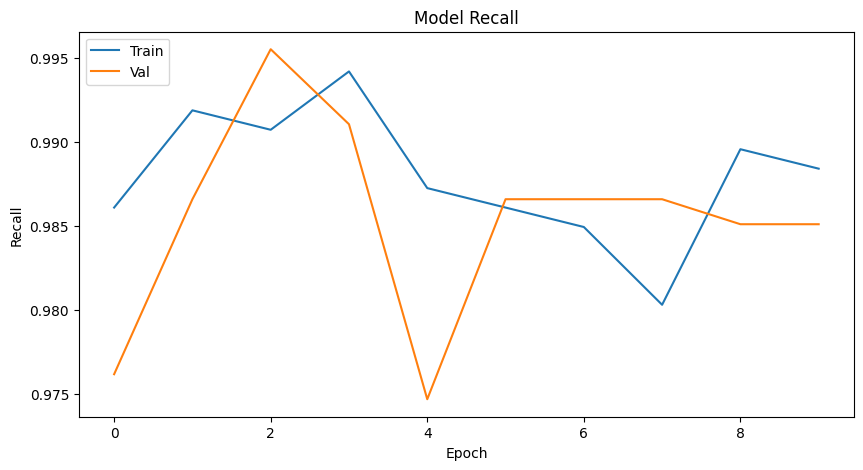

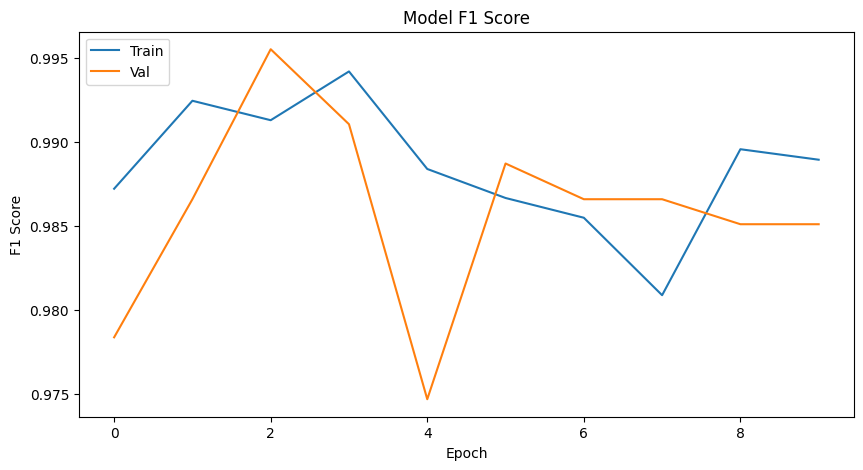

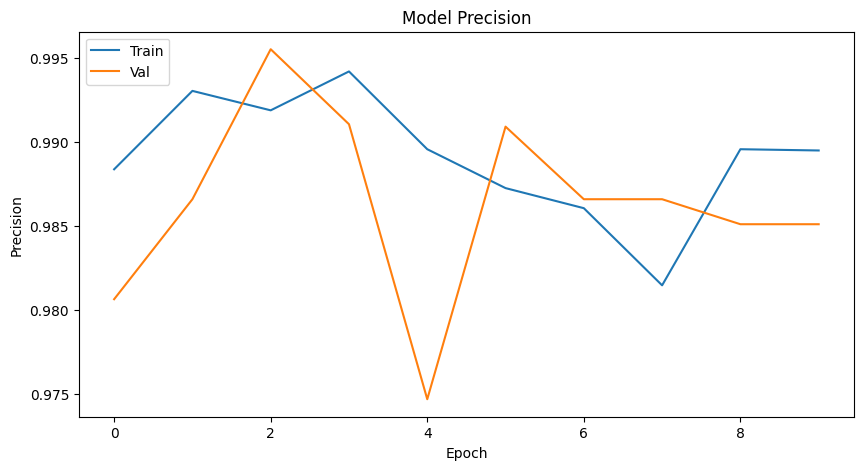

In [34]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

# fit the model
history = model.fit(train_datagen, validation_data=validation_datagen, epochs=10, verbose=1)

# plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()